In [74]:
import collections
import math
from nltk.corpus import stopwords
import numpy as np
import os
from os.path import isfile, isdir
import random
from tqdm import tqdm
import tarfile
import text_helpers
import tensorflow as tf
from urllib.request import urlretrieve

In [2]:
dataset_folder_path = 'rt-polaritydata'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('rt-polaritydata.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='rt-polaritydata.tar.gz') as pbar:
        urlretrieve(
            'http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz',
            'rt-polaritydata.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('rt-polaritydata.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [3]:
vocabulary_size = 10000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

In [4]:
# Build dictionary of words
def build_dictionary(sentences, vocabulary_size):
    # Turn sentences (list of strings) into lists of words
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    
    # Initialize list of [word, word_count] for each word, starting with unknown
    count = [['UNK', -1]]
    
    # Now add most frequent words, limited to the N-most frequent (N=vocabulary size)
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    
    # Now create the dictionary
    word_dict = {}
    # For each word, that we want in the dictionary, add it, then make it
    # the value of the prior dictionary length
    for word, _ in count:
        word_dict[word] = len(word_dict)
    
    data = []
    unk_count = 0
    for word in words:
        if word in word_dict:
            index = word_dict[word]
        else:
            index = 0 
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(word_dict.values(), word_dict.keys())) 
    
    return data, count, word_dict, reverse_dictionary

In [23]:
texts, target = text_helpers.load_movie_data(dataset_folder_path)

In [25]:
# Declare stop words
stops = stopwords.words('english')
texts = text_helpers.normalize_text(texts, stops)

# Texts must contain at least 3 words
texts = [x for x in texts if len(x.split()) > 2]

In [26]:
data, count, dictionary, reverse_dictionary= build_dictionary(texts, 10000)

In [27]:
print('Most common words (+UNK)', count[:10])
print('Sample data', data[:10])

Most common words (+UNK) [['UNK', 10138], ('film', 1445), ('movie', 1263), ('one', 726), ('like', 721), ('story', 477), ('much', 385), ('even', 382), ('good', 374), ('comedy', 356)]
Sample data [531, 2592, 2181, 0, 33, 9376, 216, 149, 16, 3680]


### Skip-gram

In [29]:
data_index = 0

# Generate data randomly (N words behind, target, N words ahead)
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  # num_skips 
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

In [30]:
print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['rock', 'destined', 'st', 'UNK', 'new', 'conan', 'hes', 'going']

with num_skips = 2 and skip_window = 1:
    batch: ['destined', 'destined', 'st', 'st', 'UNK', 'UNK', 'new', 'new']
    labels: ['rock', 'st', 'UNK', 'destined', 'new', 'st', 'conan', 'UNK']

with num_skips = 4 and skip_window = 2:
    batch: ['st', 'st', 'st', 'st', 'UNK', 'UNK', 'UNK', 'UNK']
    labels: ['destined', 'rock', 'UNK', 'new', 'new', 'destined', 'st', 'conan']


In [31]:
valid_words = ['cliche', 'love', 'hate', 'silly', 'sad']
# Get validation word keys
valid_examples = [dictionary[x] for x in valid_words]

In [32]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.float32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.nce_loss(weights=softmax_weights, biases=softmax_biases,
                                       labels=train_labels,
                                       inputs=embed,
                                       num_sampled=num_sampled,
                                       num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [33]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for j in range(len(valid_words)):
            valid_word = reverse_dictionary[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = "%s %s," % (log_str, close_word)
            print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 234.959320
Nearest to cliche: audience, blithely, padded, cinematic, lot,
Nearest to love: wartorn, scare, call, episode, pensar,
Nearest to hate: lush, jawdroppingly, rapidly, helped, away,
Nearest to silly: levy, minimalist, grandfather, cowriters, considers,
Nearest to sad: exchange, mattei, unleashes, portraying, lackluster,
Average loss at step 2000: 40.997508
Average loss at step 4000: 7.109836
Average loss at step 6000: 5.037389
Average loss at step 8000: 4.487387
Average loss at step 10000: 4.155175
Nearest to cliche: lot, meara, bracingly, thematic, plot,
Nearest to love: chatty, diehard, starred, direção, absorb,
Nearest to hate: interpretations, lush, jawdroppingly, chiefly, liu,
Nearest to silly: broomfields, prints, grandfather, considers, flavor,
Nearest to sad: exchange, connected, avantgarde, shiner, unleashes,
Average loss at step 12000: 3.919303
Average loss at step 14000: 3.722195
Average loss at step 16000: 3.575187
Average loss a

In [34]:
from sklearn.manifold import TSNE
from matplotlib import pylab

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

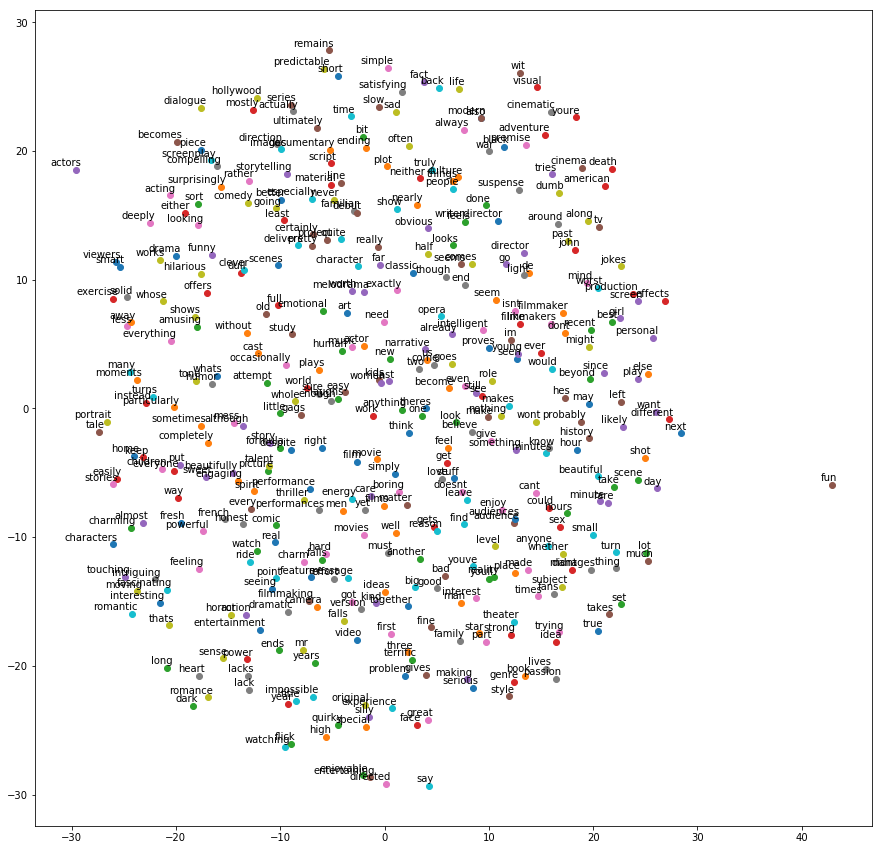

In [35]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

### CBOW

In [66]:
data_index = 0

# Helper function to understand data wrap of buffer
def print_buffer(buf):
    word_buffer = []
    for i in buf:
        word_buffer.append(reverse_dictionary[i])
    print('\n',word_buffer)

def generate_batch(batch_size, cbow_window):
  global data_index
  assert cbow_window % 2 == 0
  skip_window = int(cbow_window / 2)  
  num_labels = int(batch_size / cbow_window)
  
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(num_labels, 1), dtype=np.int32)
  span = int(2 * skip_window + 1) # [ skip_window target skip_window ]
    
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  #print_buffer(buffer)
  for i in range(num_labels):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    labels[i,0] = buffer[target]
    
    for j in range(cbow_window):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * cbow_window + j] = buffer[target]
    buffer.append(data[data_index])
    #print_buffer(buffer)
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for cbow_window in [2,4]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, cbow_window=cbow_window)
    print('\ncontext_window = %d:' % (cbow_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(len(labels))])

data: ['rock', 'destined', 'st', 'UNK', 'new', 'conan', 'hes', 'going']

context_window = 2:
    batch: ['st', 'rock', 'destined', 'UNK', 'st', 'new', 'UNK', 'conan']
    labels: ['destined', 'st', 'UNK', 'new']

context_window = 4:
    batch: ['UNK', 'new', 'destined', 'rock', 'new', 'st', 'conan', 'destined']
    labels: ['st', 'UNK']


In [70]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
cbow_window = 2 # How many words to consider left and right.
num_labels = batch_size / cbow_window

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
num_sampled = 64 # Number of negative examples to sample.

def gen_segment_ids():
  segment_ids = []
  id = -1
  for i in range(batch_size):
    if i % cbow_window == 0:
      id += 1
    segment_ids.append(id)
  return segment_ids

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.float32, shape=[num_labels, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Projection of context is sum of embeds
  segment_ids = tf.constant(gen_segment_ids())
  embed = tf.segment_sum(embed, segment_ids)
  
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.nce_loss(weights=softmax_weights, biases=softmax_biases,
                                       labels=train_labels,
                                       inputs=embed,
                                       num_sampled=num_sampled,
                                       num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [78]:
num_steps = 100001
# Create model saving operation
saver = tf.train.Saver({"embeddings": embeddings})

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, cbow_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

  # Save embeddings
  save_model_path = './movie_embeddings'
  save_path = saver.save(session, save_model_path)
  print('Model saved in file: {}'.format(save_path))

Initialized
Average loss at step 0: 236.507050
Nearest to script: mustsee, inspiration, burst, duck, graham, france, lampoons, potentially,
Nearest to funny: course, parentchild, zhangs, ode, kitten, likeable, dragons, parent,
Nearest to yet: tu, ambiguity, tucked, ultimate, catch, breezy, personal, accept,
Nearest to humor: early, charles, pessimistic, bluescreen, spider, week, cages, suppose,
Nearest to made: pgrated, mythic, ultimately, seaside, stereotyped, variations, niros, question,
Nearest to people: describe, chasing, ready, begin, sheets, courtroom, wasnt, chans,
Nearest to well: wintry, fans, scherfig, register, chokes, debated, paradiso, panorama,
Nearest to even: shaggy, arguments, tasteless, radical, intro, experiencia, kitschy, discipline,
Nearest to kind: disregard, undistinguished, poster, hearing, college, current, gutwrenching, endurance,
Nearest to big: pootie, denzel, rollerball, assembly, antidote, arteta, whats, slog,
Nearest to films: oozing, consciously, polans

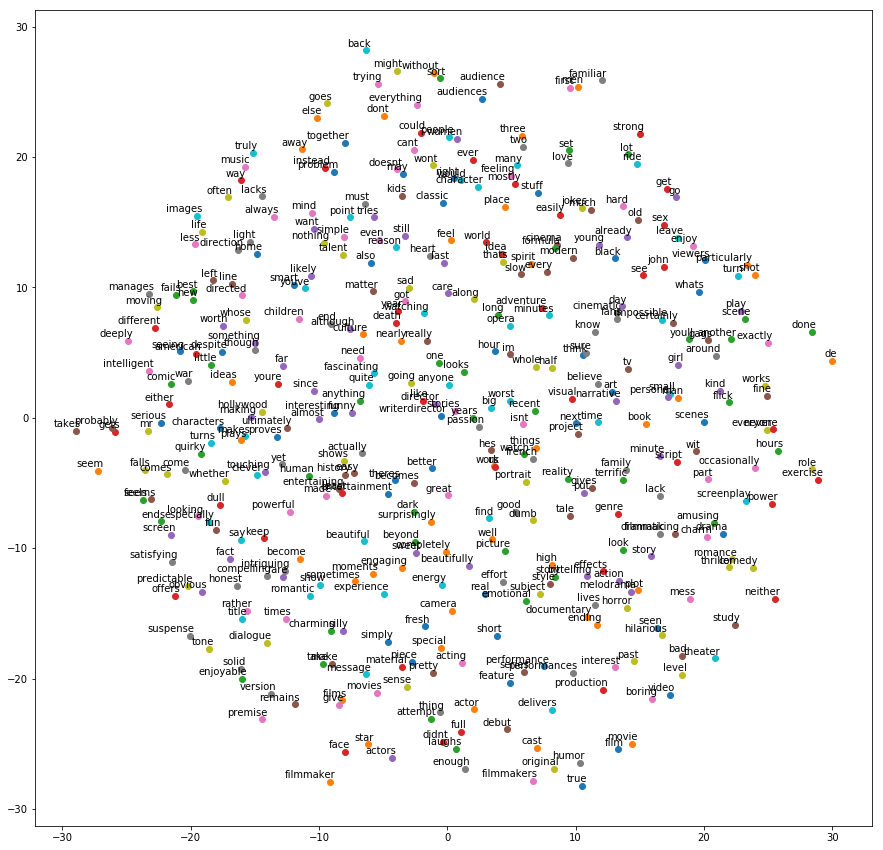

In [79]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

### Sentiment analysis